In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

[nltk_data] Downloading package wordnet to C:\Users\BARAN
[nltk_data]     JOON\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\BARAN
[nltk_data]     JOON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\BARAN
[nltk_data]     JOON\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
from nltk import pos_tag

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score

In [3]:
import re
import string
import os
from collections import defaultdict
from collections import Counter

In [4]:
plt.style.use('ggplot')
stop = set(stopwords.words('english'))

In [5]:
import gensim
from tqdm.notebook import tqdm

In [6]:
df = pd.read_csv('tweets_labeled.csv')
df.head()

,tweet_id,text,label
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0


EDA Most common words

In [8]:
def create_corpus(label):
    corpus = []
    
    for x in df.loc[df['label'] == label, 'text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

<BarContainer object of 10 artists>

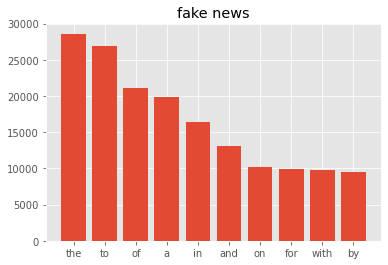

In [92]:
corpus = create_corpus(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)
plt.title('fake news')
plt.bar(x, y)

<BarContainer object of 10 artists>

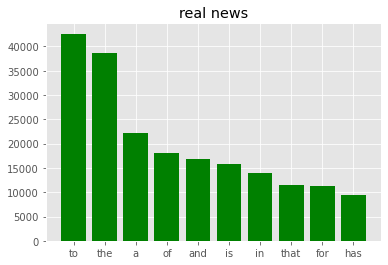

In [93]:
corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

x, y = zip(*top)

plt.title('real news')
plt.bar(x, y, color='green')

EDA punctuation

<BarContainer object of 22 artists>

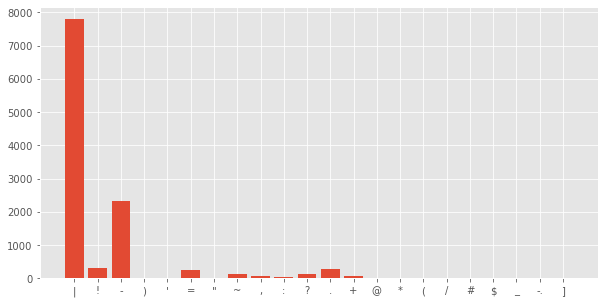

In [94]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y)

<BarContainer object of 22 artists>

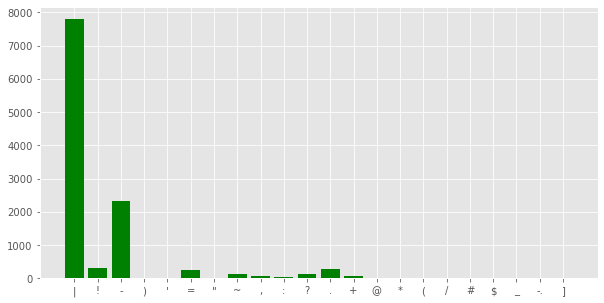

In [95]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(0)

dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1
        
x, y = zip(*dic.items())
plt.bar(x, y, color='green')

Punctuation is almost the same. Maybe we can delete it.

<AxesSubplot:>

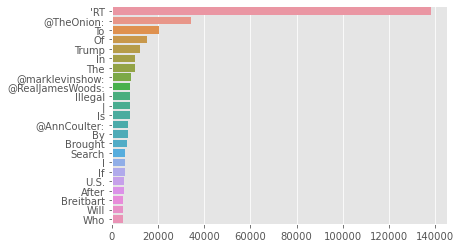

In [96]:
counter = Counter(corpus)
most_common = counter.most_common()

x = list()
y = list()

for word, count in most_common[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y, y=x, orient='h')

Bigrams

In [97]:
def get_top_tweet_bigrams(corpus, n=10):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

<AxesSubplot:>

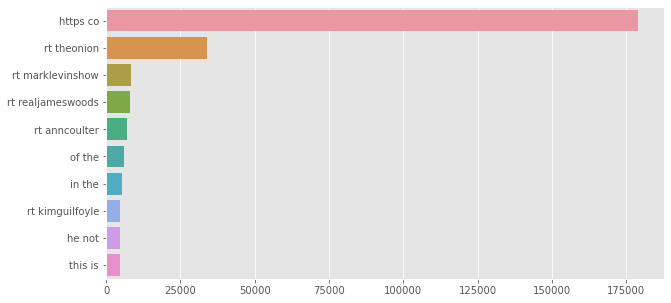

In [98]:
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(df['text'])[:10]

x, y = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=y, y=x)

Data Cleaning  We can remove URLs, HTML tags and emojis. It is hard to get information from them.

In [7]:
def clean(df):
    
    sentence = df['text'].str.replace(r'RT\s', '')
    sentence = sentence.str.replace(r'@\S*?\s', '')
    sentence = sentence.str.replace(r'@\S*?$', '')
    sentence = sentence.str.replace(r'https\S*?\s', ' ')  
    sentence = sentence.str.replace(r'https\S*?$', '')
    sentence = sentence.str.replace('\'', '')
    sentence = sentence.str.replace(r'…', '')
    sentence = sentence.str.replace(r'\s$', '')

    df['text'] = sentence
    return df

In [8]:
clean(df)

,tweet_id,text,label
0,1161040537207463936,The Endangered Species Act saved the bald eagl...,1
1,1176360756239118342,"Interesting concept -- impeach first, find fac...",1
2,1099036648573145088,#BuildTheWall #DeportThemAll,0
3,1092915693203480577,Why would the MEXICAN GOV’T fund this? Who are...,0
4,1149038450668187654,Sweden Announces Plan To Get 100% Of Energy Fr...,0
...,...,...,...
225400,1082458315865706496,Golden Globes: Anti-Gun Hollywood Surrounded B...,0
225401,1181310428850380801,Among the extreme measures being discussed abo...,1
225402,1139512030522695686,"ICE Arrests 140 Illegal Aliens, 42 with Crimin...",0
225403,1084688347040075776,Brought in by visa overstayers? NO! Brought ...,0


In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [10]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [11]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    
    return text.translate(table)

In [12]:
df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [13]:
df.head()

,tweet_id,text,label
0,1161040537207463936,The Endangered Species Act saved the bald eagl...,1
1,1176360756239118342,Interesting concept impeach first find facts ...,1
2,1099036648573145088,BuildTheWall DeportThemAll,0
3,1092915693203480577,Why would the MEXICAN GOV’T fund this Who are ...,0
4,1149038450668187654,Sweden Announces Plan To Get 100 Of Energy Fro...,0


In [14]:
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
df['text'] = [entry.lower() for entry in df['text']]

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\BARAN
[nltk_data]     JOON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df.head()

,tweet_id,text,label
0,1161040537207463936,endangered species act saved bald eagle signed...,1
1,1176360756239118342,interesting concept impeach first find facts l...,1
2,1099036648573145088,buildthewall deportthemall,0
3,1092915693203480577,would mexican gov’t fund cahoots,0
4,1149038450668187654,sweden announces plan get 100 energy unguarded...,0


In [16]:
# Step - a : Remove blank rows if any.
df['text'].dropna(inplace=True)

In [17]:
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
df['text']= [word_tokenize(entry) for entry in df['text']]

In [18]:
df.head()

,tweet_id,text,label
0,1161040537207463936,"[endangered, species, act, saved, bald, eagle,...",1
1,1176360756239118342,"[interesting, concept, impeach, first, find, f...",1
2,1099036648573145088,"[buildthewall, deportthemall]",0
3,1092915693203480577,"[would, mexican, gov, ’, t, fund, cahoots]",0
4,1149038450668187654,"[sweden, announces, plan, get, 100, energy, un...",0


In [19]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [20]:
nltk.download('averaged_perceptron_tagger')
for index,entry in enumerate(df['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else .
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'text_final'] = str(Final_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BARAN JOON\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [21]:
df.head()

,tweet_id,text,label,text_final
0,1161040537207463936,"[endangered, species, act, saved, bald, eagle,...",1,"['endanger', 'specie', 'act', 'save', 'bald', ..."
1,1176360756239118342,"[interesting, concept, impeach, first, find, f...",1,"['interest', 'concept', 'impeach', 'first', 'f..."
2,1099036648573145088,"[buildthewall, deportthemall]",0,"['buildthewall', 'deportthemall']"
3,1092915693203480577,"[would, mexican, gov, ’, t, fund, cahoots]",0,"['would', 'mexican', 'gov', 'fund', 'cahoot']"
4,1149038450668187654,"[sweden, announces, plan, get, 100, energy, un...",0,"['sweden', 'announces', 'plan', 'get', 'energy..."


In [6]:
#df.to_csv(r'C:\Users\BARAN JOON\Desktop\tweets_lemma.csv',index = False)
df = pd.read_csv('tweets_lemma.csv')
df.head()

,tweet_id,text,label,text_final
0,1161040537207463936,"['endangered', 'species', 'act', 'saved', 'bal...",1,"['endanger', 'specie', 'act', 'save', 'bald', ..."
1,1176360756239118342,"['interesting', 'concept', 'impeach', 'first',...",1,"['interest', 'concept', 'impeach', 'first', 'f..."
2,1099036648573145088,"['buildthewall', 'deportthemall']",0,"['buildthewall', 'deportthemall']"
3,1092915693203480577,"['would', 'mexican', 'gov', '’', 't', 'fund', ...",0,"['would', 'mexican', 'gov', 'fund', 'cahoot']"
4,1149038450668187654,"['sweden', 'announces', 'plan', 'get', '100', ...",0,"['sweden', 'announces', 'plan', 'get', 'energy..."


In [7]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text_final'],df['label'],test_size=0.3)

In [8]:
Tfidf_vect = TfidfVectorizer(max_features=500)
Tfidf_vect.fit(df['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [9]:
print(Tfidf_vect.vocabulary_)

{'act': 8, 'sign': 418, 'law': 260, 'republican': 387, 'president': 359, 'nothing': 318, 'interest': 234, 'impeach': 229, 'first': 176, 'find': 174, 'fact': 166, 'sound': 424, 'like': 271, 'mainstream': 282, 'medium': 293, 'write': 496, 'story': 431, 'buildthewall': 69, 'deportthemall': 129, 'would': 495, 'mexican': 296, 'announces': 24, 'plan': 344, 'get': 189, 'wall': 473, 'warren': 476, 'congress': 101, 'fail': 167, 'impeachment': 230, 'trump': 457, 'current': 110, 'former': 179, 'staff': 425, 'state': 426, 'department': 127, 'say': 398, 'ukraine': 464, 'bombshell': 57, 'much': 305, 'top': 453, 'diplomat': 131, 'real': 377, 'time': 450, 'urge': 466, 'woman': 491, 'abortion': 3, 'aag': 0, 'country': 106, 'must': 309, 'abc': 1, 'away': 38, 'show': 416, 'oscar': 331, 'back': 40, 'israel': 239, 'breitbart': 65, 'via': 469, 'bring': 67, 'visa': 470, 'overstayers': 332, 'across': 7, 'wide': 486, 'open': 330, 'border': 59, 'drug': 140, 'cartel': 78, 'million': 299, 'elect': 145, 'rep': 384

In [10]:
print(Train_X_Tfidf)

  (0, 489)	0.2762639410642986
  (0, 471)	0.2758180532897473
  (0, 423)	0.27621681198304826
  (0, 414)	0.27685695188687537
  (0, 381)	0.2765951333227537
  (0, 317)	0.27549210799599544
  (0, 306)	0.2731591484750041
  (0, 242)	0.27549210799599544
  (0, 200)	0.27683309170396364
  (0, 130)	0.2711237572664809
  (0, 67)	0.22274282765230663
  (0, 61)	0.2767139665622915
  (0, 37)	0.2691296438834238
  (0, 22)	0.20732617252209368
  (1, 469)	0.5846393431732775
  (1, 280)	0.8112933121959769
  (2, 457)	0.16163508353777006
  (2, 456)	0.2971270039132393
  (2, 442)	0.2953559324230694
  (2, 416)	0.2705444406803833
  (2, 377)	0.28088669887172385
  (2, 316)	0.2485850934175848
  (2, 245)	0.2989372653658433
  (2, 217)	0.2927039641536697
  (2, 168)	0.2802770833131234
  :	:
  (157779, 164)	0.34622364227244673
  (157779, 75)	0.2540609837919456
  (157779, 45)	0.2970809769690922
  (157779, 42)	0.2914842319670862
  (157779, 18)	0.32719290810985163
  (157780, 473)	0.31686141866007933
  (157780, 437)	0.339938694251

In [11]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  92.9165064623939


In [34]:
from sklearn import metrics
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Test_Y, predictions_SVM))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Test_Y, predictions_SVM))

Precision: 0.9787523452157598
Recall: 0.966646592856812
